In [1]:
import uproot, vector, awkward as ak, numpy as np, time, matplotlib.pyplot as plt, numba as nb

filename="user.tapark.41935082._000001.tree.root"
file = uproot.open(filename)
tree = file["JetConstituentTree"]
# tree.show()
# to read TBranch ; NOTE: use entry_start, entry_stop to read only specific amounts of entry for optimization
tjets = tree.arrays(['truthJet_pt', 'truthJet_eta', 'truthJet_phi', 'truthJet_m'], library="ak")
# add filtering on truth jets: cut="truthJet_m >= 20000"
reco_jets = tree.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_m'], library="ak")

vector.register_awkward()

zipd_t = ak.zip({"pt": tjets["truthJet_pt"], "phi": tjets["truthJet_phi"], "eta": tjets["truthJet_eta"], "m": tjets["truthJet_m"]}, with_name="Momentum4D")
zipd_t = ak.values_astype(zipd_t, "float32")

zipd_r = ak.zip({"pt": reco_jets["jet_pt"], "phi": reco_jets["jet_phi"], "eta": reco_jets["jet_eta"], "m": reco_jets["jet_m"]}, with_name="Momentum4D")
zipd_r = ak.values_astype(zipd_r, "float32")

def truthJetXIsMatch(vecT, vecR):
    return [ 1 if np.any([x.deltaR(y) < 0.4 for y in vecR]) else 0 for x in vecT]

# start = time.time()
# print("---- Running matching... ----")
# res = []
# for x,y in zip(zipd_t, zipd_r):
#     if len(x)==0:
#         continue
#     else:
#         res.append(truthJetXIsMatch(x,y)) 
# end = time.time()
# print(f"{end-start:.2f} seconds for matching procedure")
# res

In [31]:
res = []
for i in range(len(zipd_t[1].eta)):
    delta_r_row = []
    for j in range(len(zipd_r[1].eta)):
        dphi = abs(zipd_t[1].phi[i] - zipd_r[1].phi[j])
        dphi = dphi if dphi <= np.pi else 2*np.pi - dphi
        deta = zipd_t[1].eta[i] - zipd_r[1].eta[j]
        delta_r = np.sqrt(dphi**2+deta**2)
        if delta_r < 0.4:
            delta_r_row.append(1)
        else:
            delta_r_row.append(0)
    if 1 in delta_r_row:
        res.append(1)
    else:
        res.append(0)
res

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]

In [34]:
branches = ['truthJet_eta', 'truthJet_phi', 'jet_eta', 'jet_phi',]
res = []

@nb.njit
def calcDeltaR(a,b):
    res = []
    for i in range(len(a.phi)):
        delta_r_row = []
        for j in range(len(b.phi)):
            dphi = abs(a.phi[i]-b.phi[j])
            dphi = dphi if dphi <= np.pi else 2*np.pi - dphi
            deta = a.eta[i] - b.eta[j]
            delta_r = np.sqrt(dphi**2+deta**2)
            if delta_r < 0.4:
                delta_r_row.append(1)
            else:
                delta_r_row.append(0)
        if 1 in delta_r_row:
            res.append(1)
        else:
            res.append(0)
    return res
    
print("---- Running matching... ----")
s = time.time()
for arrays in tree.iterate(branches, library="ak", step_size=10000):
    s = time.time()
    zipd_t = ak.zip({"phi": arrays["truthJet_phi"], "eta": arrays["truthJet_eta"]})
    zipd_t = ak.values_astype(zipd_t, "float32")
    
    zipd_r = ak.zip({"phi": arrays["jet_phi"], "eta": arrays["jet_eta"]})
    zipd_r = ak.values_astype(zipd_r, "float32")
    for x,y in zip(zipd_t, zipd_r):
        res.append(calcDeltaR(ak.to_numpy(x),ak.to_numpy(y)))
e = time.time()
print(f"{e-s:.2f} seconds for matching")

---- Running matching... ----
1.47 seconds for matching


440000

In [ ]:
start = time.time()
print("Running matching...")
res = [main(zipd_t[x], zipd_r[x]) for x in range(len(zipd_t))]
end = time.time()
print(f"{end-start:.2f} seconds for matching procedure")

In [ ]:
res

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pts = ak.Array(tjets["truthJet_pt"].tolist())
weights = ak.Array(tjets["event_weight"].tolist())

data1 = ak.zip({"pt":pts/1000, "weight":weights})

ptsr = ak.Array(reco_jets["jet_pt"].tolist())
data1r = ak.zip({"pt":ptsr/1000, "weight":weights})

plt.hist(ak.flatten(data1)["pt"], weights=ak.flatten(data1)["weight"], alpha=0.5, bins=100, label="Truth Jet pT", color="blue", histtype="step")
plt.hist(ak.flatten(data1r)["pt"], weights=ak.flatten(data1r)["weight"], alpha=0.5, bins=100, label="Reco Jet pT", color="red", histtype="step")

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Weigh. dist. of Truth and Reconstructed Jets over pT")
plt.legend()
plt.show()

In [ ]:
etas = ak.Array(tjets["truthJet_eta"].tolist())
data2 = ak.zip({"eta":etas, "weight":weights})
etasr = ak.Array(reco_jets["jet_eta"].tolist())
data2r = ak.zip({"eta":etasr, "weight":weights})

plt.hist(ak.flatten(data2)["eta"], weights=ak.flatten(data2)["weight"], alpha=0.5, bins=100, label="Truth Jet eta", color="green", histtype="step")
plt.hist(ak.flatten(data2r)["eta"], weights=ak.flatten(data2r)["weight"], alpha=0.5, bins=100, label="Reconstr. Jet eta", color="orange", histtype="step")


plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Weigh. dist. of Truth and Reconstructed Jets over eta")
plt.legend()
plt.show()

In [286]:
# check efficiency (matched truth jets / total truth jets) for pt and eta 

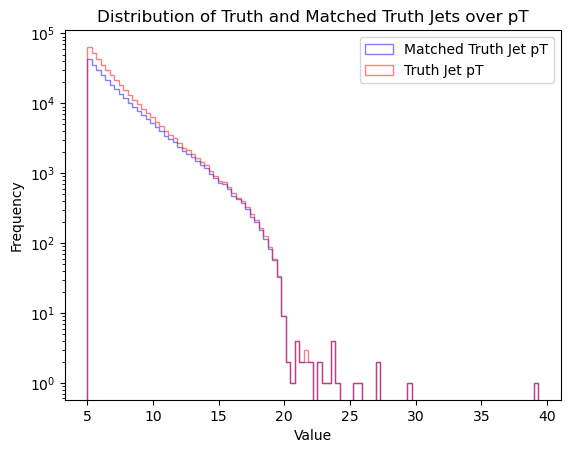

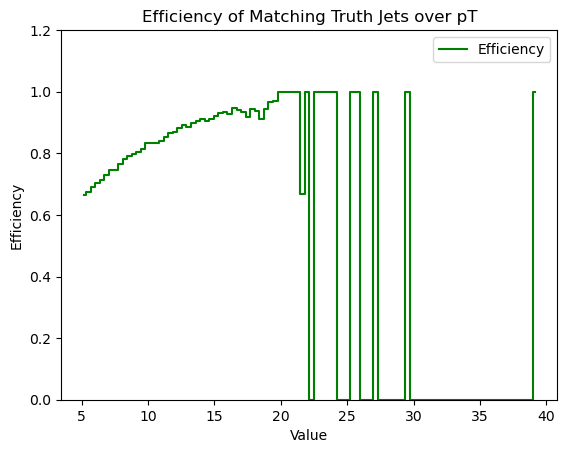

In [56]:
truth_pts = ak.Array(tjets["truthJet_pt"].tolist())
data = ak.zip({"pt":truth_pts/1000, "weight": res})

plt.figure()
numHist, bin_edges, _ = plt.hist(ak.flatten(data)["pt"], weights=ak.flatten(data)["weight"],alpha=0.5, bins=100, label="Matched Truth Jet pT", color="blue", histtype="step")
denomHist, bin_edges, _ = plt.hist(ak.flatten(data)["pt"], alpha=0.5, bins=100, label="Truth Jet pT", color="red", histtype="step")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Truth and Matched Truth Jets over pT")
plt.legend()
plt.show()


plt.figure()
efficiency = np.divide(numHist, denomHist, out=np.zeros_like(numHist), where=denomHist != 0)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.step(bin_centers ,efficiency, where="mid", label="Efficiency", color="green")


plt.xlabel("Value")
plt.ylabel("Efficiency")
plt.title("Efficiency of Matching Truth Jets over pT")
plt.ylim(0, 1.2)
plt.legend()
plt.show()

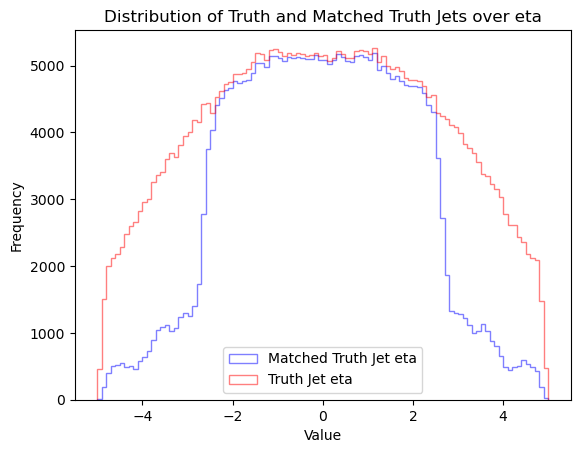

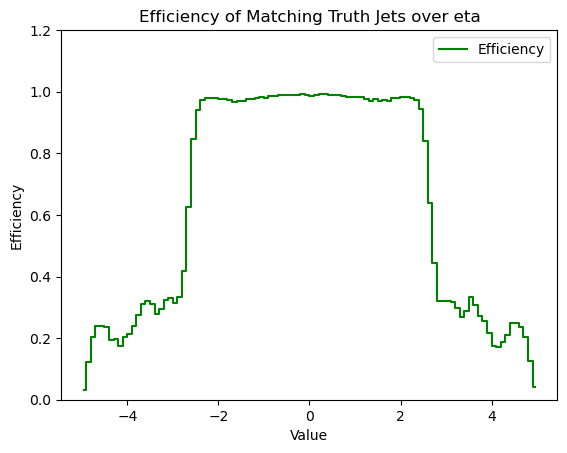

In [55]:
truth_etas = ak.Array(tjets["truthJet_eta"].tolist())
data = ak.zip({"pt":truth_etas, "weight": res})

plt.figure()
numHist, bin_edges, _ = plt.hist(ak.flatten(data)["pt"], weights=ak.flatten(data)["weight"],alpha=0.5, bins=100, label="Matched Truth Jet eta", color="blue", histtype="step")
denomHist, bin_edges, _ = plt.hist(ak.flatten(data)["pt"], alpha=0.5, bins=100, label="Truth Jet eta", color="red", histtype="step")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Truth and Matched Truth Jets over eta")
plt.legend()
plt.show()


plt.figure()
efficiency = np.divide(numHist, denomHist, out=np.zeros_like(numHist), where=denomHist != 0)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.step(bin_centers ,efficiency, where="mid", label="Efficiency", color="green")


plt.xlabel("Value")
plt.ylabel("Efficiency")
plt.title("Efficiency of Matching Truth Jets over eta")
plt.ylim(0, 1.2)
plt.legend()
plt.show()

In [ ]:
import uproot, vector, awkward as ak, numpy as np, time, matplotlib.pyplot as plt

files = [f"user.tapark.41935082._00000{x}.tree.root" for x in range(1,10)] + ["user.tapark.41935082._000010.tree.root", "user.tapark.41935082._000011.tree.root"]
columns = ['truthJet_pt', 'truthJet_eta', 'truthJet_phi', 'truthJet_m', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_m']

print("Reading data...")
read_s = time.time()
concat_data = {col: [] for col in columns}
for file in files:
    with uproot.open(file) as f:
        tree = f["JetConstituentTree"]
        for col in columns:
            # Append the column data to the list
            concat_data[col].append(tree[col].array(library="np"))

# Final concatenated arrays
for col in columns:
    concat_data[col] = np.concatenate(concat_data[col])
read_e = time.time()
print(f"{read_e-read_s:.2f} seconds for reading data")

# DATA PREP
print("Starting data prep...")
data_time_s = time.time()
tjets_pt_ak = ak.Array(concat_data["truthJet_pt"].tolist())
tjets_phi_ak = ak.Array(concat_data["truthJet_phi"].tolist())
tjets_eta_ak = ak.Array(concat_data["truthJet_eta"].tolist())
tjets_m_ak = ak.Array(concat_data["truthJet_m"].tolist())
zipd_t = ak.zip({"pt": tjets_pt_ak, "phi": tjets_phi_ak, "eta": tjets_eta_ak, "m": tjets_m_ak})
zipd_t = ak.values_astype(zipd_t, "float32")

rjets_pt_ak = ak.Array(concat_data["jet_pt"].tolist())
rjets_phi_ak = ak.Array(concat_data["jet_phi"].tolist())
rjets_eta_ak = ak.Array(concat_data["jet_eta"].tolist())
rjets_m_ak = ak.Array(concat_data["jet_m"].tolist())
zipd_r = ak.zip({"pt": rjets_pt_ak, "phi": rjets_phi_ak, "eta": rjets_eta_ak, "m": rjets_m_ak})
zipd_r = ak.values_astype(zipd_r, "float32")

data_time_e = time.time()
print(f"{data_time_e-data_time_s:.2f} seconds for data")

# MATCHING ALGORITHM
def construct_momentum(entry):
    return vector.MomentumObject4D(pt=entry["pt"] ,phi=entry["phi"], eta=entry["eta"], m=entry["m"])
    
def main(eventT:list, eventR:list):
    trueMomenta = [construct_momentum(x) for x in eventT]
    recoMomenta = [construct_momentum(x) for x in eventR]
    isReco = [ 1 if np.True_ in [ x.deltaR(y) < 0.4 for y in recoMomenta ] else 0 for x in trueMomenta ]
    return isReco

start = time.time()
print("Running matching...")
res = [main(zipd_t[x], zipd_r[x]) for x in range(len(zipd_t))]
end = time.time()
print(f"{end-start:.2f} seconds for matching procedure")

In [1]:
import uproot, vector, awkward as ak, numpy as np, numba as nb, time, os
filenameUFO = "./ufocssk/user.tapark.41935082._000001.tree.root"
filenamePFO = "./pflow/user.tapark.41935133._000001.tree.root"


def get_file_size(filename):
    file_size = os.stat(f'./{filename}').st_size
    return file_size / 1024**2

@nb.njit()
def calcDeltaR(a,b):
    res = []
    for i in range(len(a.phi)):
        delta_r_row = []
        for j in range(len(b.phi)):
            dphi = abs(a.phi[i]-b.phi[j])
            dphi = dphi if dphi <= np.pi else 2*np.pi - dphi
            deta = a.eta[i] - b.eta[j]
            delta_r = np.sqrt(dphi**2+deta**2)
            if delta_r < 0.4:
                delta_r_row.append(1)
            else:
                delta_r_row.append(0)
        if 1 in delta_r_row:
            res.append(1)
        else:
            res.append(0)
    return res

def readfiles(filename):
    print("Reading data...")
    read_s = time.time()
    file = uproot.open(filename)
    tree = file["JetConstituentTree"]
    truth_jets_data = tree.arrays(['truthJet_pt','truthJet_eta', 'truthJet_phi'], library="ak")
    reco_jets_data = tree.arrays(['jet_eta', 'jet_phi','jet_pt'], library="ak")
        
    print("---- Running matching... ----")
    s = time.time()
    zipd_t = ak.zip({"phi": truth_jets_data["truthJet_phi"], "eta": truth_jets_data["truthJet_eta"]})
    zipd_t = ak.values_astype(zipd_t, "float32")
        
    zipd_r = ak.zip({"phi": reco_jets_data["jet_phi"], "eta": reco_jets_data["jet_eta"]})
    zipd_r = ak.values_astype(zipd_r, "float32")
    res = [calcDeltaR(ak.to_numpy(x),ak.to_numpy(y)) for x,y in zip(zipd_t, zipd_r)]
    e = time.time()
    print(f"{e-s:.2f} seconds for matching of {filename} | {get_file_size(filename):.2f} MB")
    data_pt_eta_weights = ak.zip({"pt":truth_jets_data["truthJet_pt"]/1000, "eta": truth_jets_data["truthJet_eta"], "weight": res})
    return data_pt_eta_weights

ufo_data = readfiles(filenameUFO)
pfo_data = readfiles(filenamePFO)

Reading data...
---- Running matching... ----
105.80 seconds for matching of ./ufocssk/user.tapark.41935082._000001.tree.root | 196.92 MB
Reading data...
---- Running matching... ----
104.28 seconds for matching of ./pflow/user.tapark.41935133._000001.tree.root | 203.82 MB


In [ ]:
x

In [13]:
# EXTENDING A FILE WITH TRUTHJETXISRECO WEIGHTS
with uproot.open(filename) as infile:
    tree1 = infile["JetConstituentTree"]
    
with uproot.recreate(f"ext_{filename}") as outfile:
    outfile["JetConstituentTree"] = tree1
    outfile["JetXIsReco"] = x
    
file = uproot.open(f"ext_{filename}")
weights = file["JetXIsReco"].arrays(['truthJetXIsReco'], library="ak")
weights["truthJetXIsReco"]

NotImplementedError: this ROOT type is not writable: TTree

In [ ]:
import matplotlib.pyplot as plt
data = ak.zip({"eta": x["eta"], "weight": x["weight"]})

plt.figure()
numHist, bin_edges, _ = plt.hist(ak.flatten(data)["eta"], weights=ak.flatten(data)["weight"],alpha=0.5, bins=100, label="Matched Truth Jet eta", color="blue", histtype="step")
denomHist, bin_edges, _ = plt.hist(ak.flatten(data)["eta"], alpha=0.5, bins=100, label="Truth Jet eta", color="red", histtype="step")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Truth and Matched Truth Jets over eta")
plt.legend()
plt.show()


plt.figure()
efficiency = np.divide(numHist, denomHist, out=np.zeros_like(numHist), where=denomHist != 0)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.step(bin_centers ,efficiency, where="mid", label="Efficiency", color="green")


plt.xlabel("Value")
plt.ylabel("Efficiency")
plt.title("Efficiency of Matching Truth Jets over eta")
plt.ylim(0, 1.2)
plt.legend()
plt.show()